In [128]:

import numpy as np
import librosa
import os
from os import walk
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import datetime 

In [129]:
def get_mfcc(wav_file_path):
  y, sr = librosa.load(wav_file_path, offset=0, duration=30)
  mfcc = np.array(librosa.feature.mfcc(y=y, sr=sr))
  return mfcc

def get_melspectrogram(wav_file_path):
  y, sr = librosa.load(wav_file_path, offset=0, duration=30)
  melspectrogram = np.array(librosa.feature.melspectrogram(y=y, sr=sr))
  return melspectrogram

def get_chroma_vector(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  chroma = np.array(librosa.feature.chroma_stft(y=y, sr=sr))
  return chroma

def get_tonnetz(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  tonnetz = np.array(librosa.feature.tonnetz(y=y, sr=sr))
  return tonnetz

In [130]:
example_file = r"Chords_generation\3c_prog_wav\prog_wav\G_A#augG_A#dimG_D#dim.wav"
y, sr = librosa.load(example_file, offset=0, duration=30)

[Text(0.5, 1.0, 'MFCC pour un La maj')]

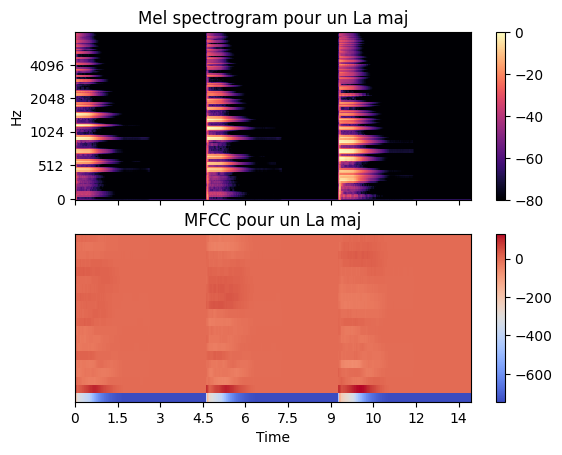

In [131]:
S = get_melspectrogram(example_file)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)

mfcc = get_mfcc(example_file)

fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram pour un La maj')
ax[0].label_outer()
img = librosa.display.specshow(mfcc, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC pour un La maj')

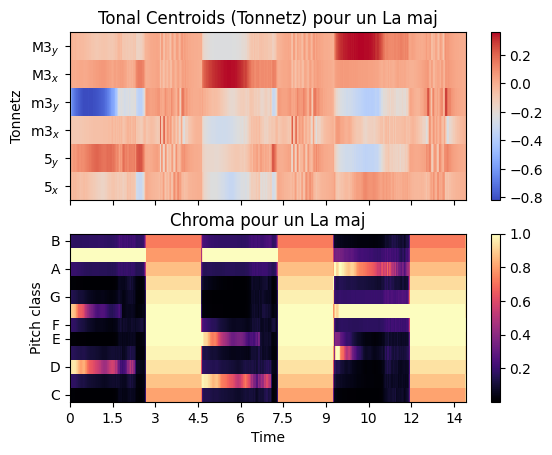

In [132]:
import matplotlib.pyplot as plt
chroma = get_chroma_vector(example_file)
tntz = get_tonnetz(example_file)

fig, ax = plt.subplots(nrows=2, sharex=True)
img1 = librosa.display.specshow(tntz,
                                y_axis='tonnetz', x_axis='time', ax=ax[0])
ax[0].set(title='Tonal Centroids (Tonnetz) pour un La maj')
ax[0].label_outer()
img2 = librosa.display.specshow(chroma,
                                y_axis='chroma', x_axis='time', ax=ax[1])
ax[1].set(title='Chroma pour un La maj')
fig.colorbar(img1, ax=[ax[0]])
fig.colorbar(img2, ax=[ax[1]])

In [133]:
# J'ai gardé les 2 composantes que je trouve les plus logiques ne attendnat d'en savoir plus 
# Va nous renvoyé les 128 freq moyenne, puis les 128 mion et enfin les 128 max
# Va nous renvoyé 12 * 3 = 36 valeurs, les 12 premières correspondent à la moyenne, puis au min et enfin au max

def get_feature(file_path):
  features = []

  # # Extracting mal spectrogram vector feature
  melspectrogram = get_melspectrogram(file_path)
  melspectrogram_mean = melspectrogram.mean(axis=1)
  features = melspectrogram_mean

  # Extracting chroma vector feature
  chroma = get_chroma_vector(file_path)
  chroma_mean = chroma.mean(axis=1)
  features = np.concatenate([features, chroma_mean])
  
  return features 

In [134]:
def extract_features(directory):
    features = []
    labels = []
    label_encoder = LabelEncoder()

    for root, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            feature = get_feature(file_path)
            label = file.split('_')[1].split('.')[0]
            features.append(feature)
            labels.append(label)

    # Conversion des noms d'accords en valeurs numériques
    labels_encoded = label_encoder.fit_transform(labels)

    return features, labels_encoded

In [135]:
dir = 'Chords_generation\chords_wav'
features, labels = extract_features(dir)

In [136]:
# Normalisation des caractéristiques
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [137]:
model = keras.Sequential()
model.add(keras.layers.Input(shape=(140,)))
model.add(keras.layers.Dense(35, activation='relu'))
model.add(keras.layers.Dense(103, activation='softmax'))
model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [138]:

HISTORY=model.fit(X_train,y_train,epochs=20,validation_split=0.3)

Epoch 1/20
8/8 [==============================] - 1s 27ms/step - loss: 4.8493 - accuracy: 0.0132 - val_loss: 4.8582 - val_accuracy: 0.0102
Epoch 2/20
8/8 [==============================] - 0s 8ms/step - loss: 4.6713 - accuracy: 0.0175 - val_loss: 4.8612 - val_accuracy: 0.0000e+00
Epoch 3/20
8/8 [==============================] - 0s 7ms/step - loss: 4.5446 - accuracy: 0.0263 - val_loss: 4.8655 - val_accuracy: 0.0000e+00
Epoch 4/20
8/8 [==============================] - 0s 7ms/step - loss: 4.4270 - accuracy: 0.0395 - val_loss: 4.8765 - val_accuracy: 0.0000e+00
Epoch 5/20
8/8 [==============================] - 0s 7ms/step - loss: 4.3243 - accuracy: 0.0482 - val_loss: 4.8823 - val_accuracy: 0.0000e+00
Epoch 6/20
8/8 [==============================] - 0s 7ms/step - loss: 4.2265 - accuracy: 0.0614 - val_loss: 4.8914 - val_accuracy: 0.0000e+00
Epoch 7/20
8/8 [==============================] - 0s 7ms/step - loss: 4.1321 - accuracy: 0.1053 - val_loss: 4.9051 - val_accuracy: 0.0000e+00
Epoch 8/2

In [144]:
import random
import numpy as np 


# Choisissez un exemple aléatoire dans l'ensemble de test
index = random.randint(0, len(X_test) - 1)
input_test = np.expand_dims(X_test[index], axis=0)  # Convertir en forme (1, num_features) pour une prédiction unique

# Faites la prédiction
prediction = model.predict(input_test)

classe = np.argmax(prediction)

taux_confiance = max(prediction[0]) * 100

print(f'Prédiction de classe : {classe}')
print(f'Taux de confiance : {taux_confiance}%')


1/1 [==============================] - 0s 28ms/step
Prédiction de classe : 59
Taux de confiance : 3.2505925744771957%


In [140]:
y_pred = model.predict(X_test)
pred = []
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))

count = 0
for i in range(len(pred)):
    if pred[i] == y_test[i]:
        count+=1

string = "Performance : " + str(count/len(y_test)*100) + "%"
print(string)

3/3 [==============================] - 0s 3ms/step
Performance : 2.4390243902439024%
